In [770]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import seaborn as sns
import lightgbm as lgb
from lightgbm import LGBMClassifier
import os
from sklearn.metrics import roc_auc_score, accuracy_score
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from warnings import filterwarnings
from time import time
import time
import datetime
from datetime import datetime
import pickle
from glob import glob
from tqdm import tqdm
import joblib

filterwarnings('ignore')
pd.options.display.max_columns = 999

from func import distribution_draw


In [771]:
# 추후 시간이 오래걸리는 FE, row 변경에 영향도가 없는 FE 분리

def feature_engineering_origin(raw_test):
    test = raw_test.copy()
    test.sort_values(by=['userID', 'Timestamp'], inplace=True)
    test.join(test.groupby('userID')['answerCode'].count().to_frame('count'), on='userID', how='left')

    def convert_time(s):
        timestamp = time.mktime(datetime.strptime(s, '%Y-%m-%d %H:%M:%S').timetuple())
        return int(timestamp)

    test['time'] = test['Timestamp'].apply(convert_time)
    test['Timestamp'] = test['Timestamp'].astype('datetime64')
    test['test_group'] = test['testId'].astype('str').apply(lambda x: x[2])
    
    # add
    test['time'] = test['time'] - test['time'].shift(1)
    test.loc[0,'time'] = 0
    
    test['testId'] = test['testId'].apply(lambda x: int(x[2:]))
    test['temp_test'] = test['testId'].shift(1)
    test.loc[0,'temp_test'] = 0
    test['temp_test'] = test['temp_test'] - test['testId']
    test['temp_test'] = test['temp_test'].apply(lambda x: 0 if x != 0.0 else 1)
    test['time'] = test['time'] * test['temp_test']
    test['time_cum'] = test.groupby(['userID','testId'])['time'].transform(lambda x: x.cumsum())

    test['meantime_3'] = test.groupby('userID')['time'].rolling(3).mean().values # rolling 앞의 3개 평균
    total_used_time = test.groupby('userID')['time'].cumsum().shift(1).to_frame('total_used_time').fillna(0)
    test = pd.concat([test, total_used_time],1)
    
    return test


def feature_engineering(raw_test):
    test = raw_test.copy()
    
    #유저들의 문제 풀이수, 정답 수, 정답률을 시간순으로 누적해서 계산
    test['user_correct_answer'] = test.groupby('userID')['answerCode'].transform(lambda x: x.cumsum().shift(1))
    test['user_total_answer'] = test.groupby('userID')['answerCode'].cumcount()
    test['user_acc'] = test['user_correct_answer']/test['user_total_answer']

    total_prob = test.groupby('userID')['answerCode'].count().to_frame('total_prob').reset_index()
    test = pd.merge(test, total_prob, how='left', on ='userID')
    test['total_prob'] = test['total_prob'] - test['user_correct_answer']

    # testId와 KnowledgeTag의 전체 정답률은 한번에 계산
    # 아래 데이터는 제출용 데이터셋에 대해서도 재사용
    # 서비스 기준에 따라 변경됨
    correct_t = test.groupby(['testId'])['answerCode'].agg(['mean', 'sum'])
    correct_t.columns = ["test_mean", 'test_sum']
    correct_k = test.groupby(['KnowledgeTag'])['answerCode'].agg(['mean', 'sum'])
    correct_k.columns = ["tag_mean", 'tag_sum']

    test = pd.merge(test, correct_t, on=['testId'], how="left")
    test = pd.merge(test, correct_k, on=['KnowledgeTag'], how="left")

    return test

In [772]:
valid = pd.read_csv('valid_set.csv')
display(valid.head(), valid.shape)

,index,userID,assessmentItemID,testId,answerCode,Timestamp,KnowledgeTag,fold,time,temp_test,time_cum,test_group,total_used_time,meantime_3,user_correct_answer,user_total_answer,user_acc,total_prob,test_mean,test_sum,tag_mean,tag_sum,proba
0,0,0,A060001001,60000001,1,2020-03-24 00:17:11,7224,0,0.0,0,0.0,6,0.0,NaN,NaN,0,NaN,NaN,0.947683,1268,0.955022,637,NaN
1,1,0,A060001002,60000001,1,2020-03-24 00:17:14,7225,0,3.0,1,3.0,6,0.0,NaN,1.0,1,1.0,744.0,0.947683,1268,0.913187,3040,NaN
2,2,0,A060001003,60000001,1,2020-03-24 00:17:22,7225,0,8.0,1,11.0,6,3.0,3.666667,2.0,2,1.0,743.0,0.947683,1268,0.913187,3040,NaN
3,3,0,A060001004,60000001,1,2020-03-24 00:17:29,7225,0,7.0,1,18.0,6,11.0,6.000000,3.0,3,1.0,742.0,0.947683,1268,0.913187,3040,NaN
4,4,0,A060001005,60000001,1,2020-03-24 00:17:36,7225,0,7.0,1,25.0,6,18.0,7.333333,4.0,4,1.0,741.0,0.947683,1268,0.913187,3040,NaN


(2266586, 23)

In [773]:
model = joblib.load('lgbm_model.pkl')
model

LGBMClassifier(n_estimators=500, num_leaves=255)

In [620]:
with open('feature_pickle.pickle', 'rb') as f:
    FEATURES = pickle.load(f)
FEATURES

['KnowledgeTag',
 'user_correct_answer',
 'user_total_answer',
 'user_acc',
 'total_prob',
 'test_mean',
 'test_sum',
 'tag_mean',
 'tag_sum',
 'time',
 'time_cum',
 'total_used_time',
 'meantime_3']

In [621]:
%%time
raw_test = '/opt/ml/input/data/train_dataset/test_data.csv'
#feat_test = 'test_set.csv'
raw_test = pd.read_csv(raw_test)
raw_test = feature_engineering_origin(raw_test)
#feat_test = pd.read_csv(feat_test)

CPU times: user 17.5 s, sys: 416 ms, total: 17.9 s
Wall time: 17.5 s


## Cut raw_test by user
1. FE 가 시간이 너무 오래 걸린다. -> FE code 를 수정함으로써 시간을 단축
2. inference 를 위해, 고객 대상 service 를 위해 어떤 수정이 이루어져야 하나?
    if) 만약 한 유저의 예측 추이를 확인하려면? 
        ex) 전체를 대상으로 최종 FE 진행, 특정 user 의 time sequence 50개(by user, count of prob) 를 dataframe 으로 만들어 inference 에 input  
            전체를 대상으로 FE 는 다른 test 나 문제에 대해 통계 자료를 활용하기 위해서 + model 학습 시 이용한 FEATURE 때문  
            -> groupby('test_id'), groupby('KnowledgeTag') -> 만약 service 상 정답률을 약간 포기하고서라도 완전히 user의 데이터만 input 하려면, 이 FEATURE 를 제거하고 재설계  
  
----

`So, 현재 sequence`  
    1. 원하는 유저를 선택  
    2. 그 유저의 통계자료 추출  
    3. 그 유저의 count 에 따른 마지막 sequence 비율을 정하고(혹은 갯수를 정하고)   
    4. 유저의 sequence-1개 row 를 추출  
    5. (원칙적으로) row 가 없을 때마다 FE  
    6. 결괏값 비교  
            


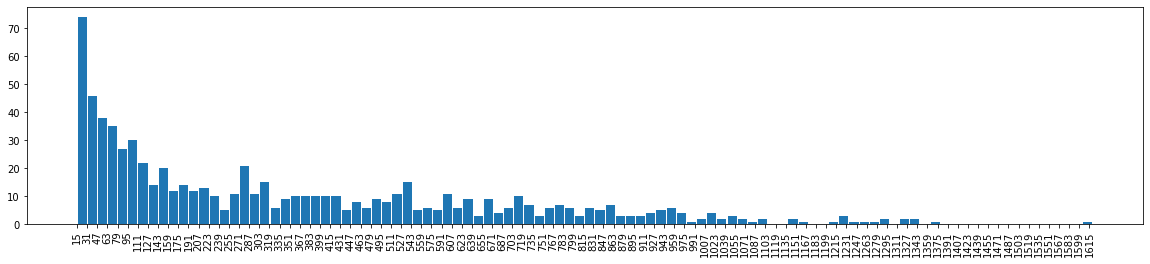

In [622]:
# user 별 푼 문제 수
prob_count = raw_test.groupby('userID')['answerCode'].count()
plt.figure(figsize=(20,4))
plt.hist(prob_count, bins=100, rwidth=0.9)
_min = prob_count.min()
_max = prob_count.max()
plt.xticks(np.arange(_min, _max, int((_max-_min)//100)), rotation=90)
plt.show();

In [623]:
# 이전에 조건을 주어야 할까? FE 가 반복되면 시간이 너무 오래걸린다.
# FE code 를 수정함으로써 시간을 단축
raw_test

,userID,assessmentItemID,testId,answerCode,Timestamp,KnowledgeTag,time,test_group,temp_test,time_cum,meantime_3,total_used_time
0,3,A050023001,50000023,1,2020-01-09 10:56:31,2626,0.0,5,0,0.0,NaN,0.0
1,3,A050023002,50000023,1,2020-01-09 10:56:57,2626,26.0,5,1,26.0,NaN,0.0
2,3,A050023003,50000023,0,2020-01-09 10:58:31,2625,94.0,5,1,120.0,40.000000,26.0
3,3,A050023004,50000023,0,2020-01-09 10:58:36,2625,5.0,5,1,125.0,41.666667,120.0
4,3,A050023006,50000023,0,2020-01-09 10:58:43,2623,7.0,5,1,132.0,35.333333,125.0
...,...,...,...,...,...,...,...,...,...,...,...,...
260109,7439,A040130001,40000130,0,2020-10-14 23:07:23,8832,0.0,4,0,0.0,14.666667,371.0
260110,7439,A040130002,40000130,1,2020-10-14 23:07:41,8832,18.0,4,1,18.0,7.666667,371.0
260111,7439,A040130003,40000130,1,2020-10-14 23:08:02,8244,21.0,4,1,39.0,13.000000,389.0
260112,7439,A040130004,40000130,1,2020-10-14 23:09:31,8244,89.0,4,1,128.0,42.666667,410.0


In [624]:
%%time
test_df = feature_engineering(raw_test) # 전체 0.5s

CPU times: user 500 ms, sys: 0 ns, total: 500 ms
Wall time: 501 ms


In [625]:
sampling = test_df[test_df['userID']==3]
sample = sampling.iloc[-50:]
sampling.shape, sample.shape

((1036, 20), (50, 20))

In [626]:
def set_df(test, features):
    y = test['answerCode']
    test2 = test.drop('answerCode', axis=1)
    return test2[features], y

In [627]:
testing, y = set_df(sample, FEATURES)

In [628]:
result = model.predict_proba(testing)

In [629]:
testing['y_true'] = y
testing['y_pred'] = result[:,1]
testing = testing.iloc[:-1]
zero = testing[testing['y_true'] == 0]
one = testing[testing['y_true'] == 1]
display(testing.head(), testing.shape)

,KnowledgeTag,user_correct_answer,user_total_answer,user_acc,total_prob,test_mean,test_sum,tag_mean,tag_sum,time,time_cum,total_used_time,meantime_3,y_true,y_pred
986,5298,690.0,986,0.699797,346.0,0.528571,74,0.621918,227,5.0,28.0,50259.0,9.333333,0,0.415084
987,5298,690.0,987,0.699088,346.0,0.528571,74,0.621918,227,3.0,31.0,50264.0,7.000000,0,0.311069
988,5298,690.0,988,0.698381,346.0,0.528571,74,0.621918,227,2.0,33.0,50267.0,3.333333,0,0.315307
989,5298,690.0,989,0.697674,346.0,0.528571,74,0.621918,227,3.0,36.0,50269.0,2.666667,0,0.340502
990,426,690.0,990,0.696970,346.0,0.456140,52,0.684211,26,0.0,0.0,50272.0,1.666667,0,0.621208


(49, 15)

In [630]:
print(f"Total  : {len(testing)}", end=' | ')
print(f"y_zero : {len(zero)}", end=' | ')
print(f"y_one  : {len(one)}")

Total  : 49 | y_zero : 22 | y_one  : 27


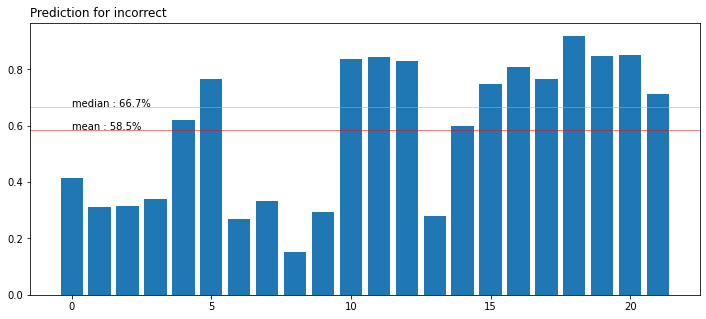

In [631]:
plt.figure(figsize=(12,5))
plt.bar(np.arange(len(zero)), zero['y_pred'])
_mean = zero['y_pred'].mean()
_median = zero['y_pred'].median()
plt.axhline(y = _mean, color='r', ls= '-', lw=0.5)
plt.axhline(y = _median, color='orange', ls= '-', lw=0.5)
plt.text(x = 0, y = _mean, s = f"mean : {_mean*100:.1f}%")
plt.text(x = 0, y = _median, s = f"median : {_median*100:.1f}%")
plt.title('Prediction for incorrect', loc='left')
plt.show();

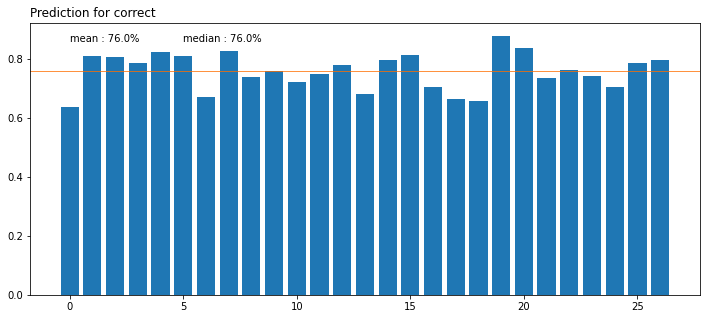

In [632]:
plt.figure(figsize=(12,5))
plt.bar(np.arange(len(one)), one['y_pred'])
_mean = one['y_pred'].mean()
_median = one['y_pred'].mean()
plt.axhline(y = _mean, color='r', ls= '-', lw=0.5)
plt.axhline(y = _median, color='orange', ls= '-', lw=0.5)
plt.text(x = 0, y = _mean+0.1, s = f"mean : {_mean*100:.1f}%")
plt.text(x = 5, y = _median+0.1, s = f"median : {_median*100:.1f}%")
plt.title('Prediction for correct', loc='left')
plt.show();

In [633]:
zero['y_pred'].max(), one['y_pred'].min()

(0.9191269633988377, 0.6382221327924108)

In [634]:
threshold = 0.5
testing['prediction'] = (testing['y_pred'] > threshold).astype('int')

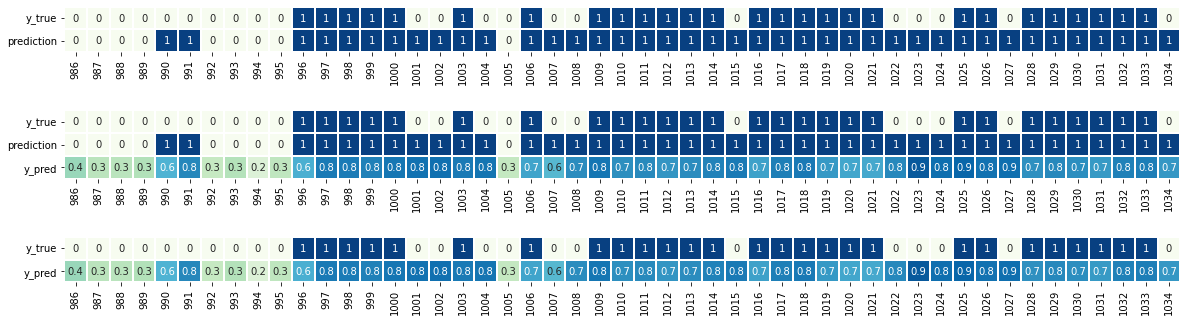

In [635]:
fig, axes = plt.subplots(3,1,figsize=(20,6))
sns.heatmap(testing[['y_true','prediction']].transpose(),
            cbar=False,
            square=True,linewidths=0.2, annot=True, cmap='GnBu', ax = axes[0])
sns.heatmap(testing[['y_true', 'prediction', 'y_pred']].transpose(),
            cbar=False,
            square=True,linewidths=0.2, annot=True, cmap='GnBu', fmt='.1g', ax = axes[1])
sns.heatmap(testing[['y_true', 'y_pred']].transpose(),
            cbar=False,
            square=True,linewidths=0.2, annot=True, cmap='GnBu', fmt='.1g', ax = axes[2])
plt.show();

In [636]:
print(f"Accuracy score : {accuracy_score(testing['y_true'], testing['prediction']) * 100 :.2f} %")

Accuracy score : 73.47 %


In [637]:
df = sampling.copy()
df.loc[list(df.iloc[-50:].index), FEATURES] = testing
df['y_pred'] = testing['y_pred']
df['prediction'] = testing['prediction']
df = df.iloc[:-1]

In [638]:
df

,userID,assessmentItemID,testId,answerCode,Timestamp,KnowledgeTag,time,test_group,temp_test,time_cum,meantime_3,total_used_time,user_correct_answer,user_total_answer,user_acc,total_prob,test_mean,test_sum,tag_mean,tag_sum,y_pred,prediction
0,3,A050023001,50000023,1,2020-01-09 10:56:31,2626.0,0.0,5,0,0.0,NaN,0.0,NaN,0.0,NaN,NaN,0.473214,106.0,0.587097,91.0,NaN,NaN
1,3,A050023002,50000023,1,2020-01-09 10:56:57,2626.0,26.0,5,1,26.0,NaN,0.0,1.0,1.0,1.000000,1035.0,0.473214,106.0,0.587097,91.0,NaN,NaN
2,3,A050023003,50000023,0,2020-01-09 10:58:31,2625.0,94.0,5,1,120.0,40.000000,26.0,2.0,2.0,1.000000,1034.0,0.473214,106.0,0.588517,123.0,NaN,NaN
3,3,A050023004,50000023,0,2020-01-09 10:58:36,2625.0,5.0,5,1,125.0,41.666667,120.0,2.0,3.0,0.666667,1034.0,0.473214,106.0,0.588517,123.0,NaN,NaN
4,3,A050023006,50000023,0,2020-01-09 10:58:43,2623.0,7.0,5,1,132.0,35.333333,125.0,2.0,4.0,0.500000,1034.0,0.473214,106.0,0.581986,252.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1030,3,A050133003,50000133,1,2020-10-26 13:10:22,5289.0,54.0,5,1,101.0,33.666667,52732.0,713.0,1030.0,0.692233,323.0,0.661765,90.0,0.542662,159.0,0.742924,1.0
1031,3,A050133004,50000133,1,2020-10-26 13:12:11,5289.0,109.0,5,1,210.0,70.000000,52786.0,714.0,1031.0,0.692532,322.0,0.661765,90.0,0.542662,159.0,0.706507,1.0
1032,3,A050133005,50000133,1,2020-10-26 13:12:36,5288.0,25.0,5,1,235.0,62.666667,52895.0,715.0,1032.0,0.692829,321.0,0.661765,90.0,0.601852,130.0,0.787880,1.0
1033,3,A050133006,50000133,1,2020-10-26 13:12:52,5288.0,16.0,5,1,251.0,50.000000,52920.0,716.0,1033.0,0.693127,320.0,0.661765,90.0,0.601852,130.0,0.799038,1.0


In [639]:
check = df.iloc[-49:]
display(check.head(), check.shape)

,userID,assessmentItemID,testId,answerCode,Timestamp,KnowledgeTag,time,test_group,temp_test,time_cum,meantime_3,total_used_time,user_correct_answer,user_total_answer,user_acc,total_prob,test_mean,test_sum,tag_mean,tag_sum,y_pred,prediction
986,3,A050135004,50000135,0,2020-10-12 09:50:04,5298.0,5.0,5,1,28.0,9.333333,50259.0,690.0,986.0,0.699797,346.0,0.528571,74.0,0.621918,227.0,0.415084,0.0
987,3,A050135005,50000135,0,2020-10-12 09:50:07,5298.0,3.0,5,1,31.0,7.000000,50264.0,690.0,987.0,0.699088,346.0,0.528571,74.0,0.621918,227.0,0.311069,0.0
988,3,A050135006,50000135,0,2020-10-12 09:50:09,5298.0,2.0,5,1,33.0,3.333333,50267.0,690.0,988.0,0.698381,346.0,0.528571,74.0,0.621918,227.0,0.315307,0.0
989,3,A050135007,50000135,0,2020-10-12 09:50:12,5298.0,3.0,5,1,36.0,2.666667,50269.0,690.0,989.0,0.697674,346.0,0.528571,74.0,0.621918,227.0,0.340502,0.0
990,3,A050136001,50000136,0,2020-10-14 10:38:52,426.0,0.0,5,0,0.0,1.666667,50272.0,690.0,990.0,0.696970,346.0,0.456140,52.0,0.684211,26.0,0.621208,1.0


(49, 22)

In [640]:
check['y_pred'].sum()/check['y_pred'].count()

0.681318519033413

In [641]:
top_incorrect = check.sort_values(by='y_pred')[check['y_pred']<0.5]
top_incorrect
# 모델의 예측 proba 값이 0.5 이하인 것들 : 어떤 상태이길래 모델이 틀렸다고 예측하는가? -> 현상 중에 문제가 있을 수 있다. -> FEATURE 분석 -> 현상과 원인으로 분석

,userID,assessmentItemID,testId,answerCode,Timestamp,KnowledgeTag,time,test_group,temp_test,time_cum,meantime_3,total_used_time,user_correct_answer,user_total_answer,user_acc,total_prob,test_mean,test_sum,tag_mean,tag_sum,y_pred,prediction
994,3,A050136005,50000136,0,2020-10-14 10:41:58,425.0,3.0,5,1,186.0,2.666667,50455.0,690.0,994.0,0.694165,346.0,0.456140,52.0,0.498575,175.0,0.152043,0.0
992,3,A050136003,50000136,0,2020-10-14 10:41:52,425.0,2.0,5,1,180.0,60.000000,50450.0,690.0,992.0,0.695565,346.0,0.456140,52.0,0.498575,175.0,0.270911,0.0
1005,3,A050145003,50000145,0,2020-10-19 13:28:54,427.0,4.0,5,1,338.0,112.666667,51115.0,696.0,1005.0,0.692537,340.0,0.733333,88.0,0.780543,345.0,0.278821,0.0
995,3,A050136006,50000136,0,2020-10-14 10:42:03,5300.0,5.0,5,1,191.0,3.666667,50458.0,690.0,995.0,0.693467,346.0,0.456140,52.0,0.527607,86.0,0.295693,0.0
987,3,A050135005,50000135,0,2020-10-12 09:50:07,5298.0,3.0,5,1,31.0,7.000000,50264.0,690.0,987.0,0.699088,346.0,0.528571,74.0,0.621918,227.0,0.311069,0.0
988,3,A050135006,50000135,0,2020-10-12 09:50:09,5298.0,2.0,5,1,33.0,3.333333,50267.0,690.0,988.0,0.698381,346.0,0.528571,74.0,0.621918,227.0,0.315307,0.0
993,3,A050136004,50000136,0,2020-10-14 10:41:55,425.0,3.0,5,1,183.0,61.000000,50452.0,690.0,993.0,0.694864,346.0,0.456140,52.0,0.498575,175.0,0.334037,0.0
989,3,A050135007,50000135,0,2020-10-12 09:50:12,5298.0,3.0,5,1,36.0,2.666667,50269.0,690.0,989.0,0.697674,346.0,0.528571,74.0,0.621918,227.0,0.340502,0.0
986,3,A050135004,50000135,0,2020-10-12 09:50:04,5298.0,5.0,5,1,28.0,9.333333,50259.0,690.0,986.0,0.699797,346.0,0.528571,74.0,0.621918,227.0,0.415084,0.0


### top_incorrect.columns
|column|content|cause or effect|comment|
|-|-|-|-|
|userID|유저의 아이디|None||
|assessmentItemID|시험지 + 문제 아이디|cause|카테고리화가 불가능-사용불가|
|testId|시험지|cause|카테고리가 많으나 사용은 가능-difficulty of test by all user|
|KnowledgeTag|고유 tag|cause|난이도 관련하여 사용가능|
|`time`|걸린 시간|cause|문제 난이도로 사용가능|
|test_group|테스트 그룹|cause|난이도로 사용가능|
|time_cum|시험지별 누적 시간|cause|사용은 가능함(피로도, 누적 학습시간). 그러나 원칙적으로 시험은 따로본다는 가정하에 없어야할 column|
|meantime_3|최근 3문제 평균 문제풀이 시간|cause|사용가능(개별 문제)|
|total_used_time|총 문제풀이에 사용한 시간|cause|사용가능. 제대로 사용하려면, 마지막 50개가 아닌 중간 50개를 추가로 뽑아 비교실험하면 가능|
|user_total_answer|총 문제 수|cause|문제 풀이 수 로서 얼마나 공부했는지는 사용가능|
|user_correct_answer|맞춘 문제 수|effect|문제별 정확도에는 영향을 줄 수 없고, 특정 카테고리를 얼마나 풀었는지 와 같은 요소를 따로 체크해야 한다. 전체 경향성을 파악하는데는 가능|
|total_prob|못 맞춘 문제 수|effect|문제별 정확도에는 영향을 줄 수 없고, 특정 카테고리를 얼마나 틀렸는지 와 같은 요소를 따로 체크해야 한다. 전체 경향성을 파악하는데는 가능(쪼개서)|
|user_acc|현재 문제까지의 정확도|effect|원인 분석에는 사용 불가능|
|test_mean|시험지별 정답률|cause|시험지의 난이도 측정에 사용가능. but, test dataset, train dataset 분포 비교 필요|
|test_sum|시험지별 user 들이 전체 맞춘 개수|cause||
|tag_mean|tag 별 정답률|cause||
|tag_sum|tag 별 user 들이 전체 맞춘 개수|cause||

In [642]:
# 주어진 기본 컬럼 + FE 컬럼 + answerCode + y_pred
# 똑같이 틀렸거나 맞았더라도, 그 확률이 다르다. y_pred 는 그 지식상태를 보여준다. 틀렸지만, 넌 이만큼 알고 있고, 맞았지만 넌 이만큼 알고 있어.
# 그러면 실질적인 학습에 대한 결과를 추론할 수 있는 데이터가 필요하다.

In [643]:
df['assessmentItemID'].nunique(), df['testId'].nunique(), df['KnowledgeTag'].nunique(), df['test_group'].nunique()

(825, 130, 93, 2)

In [644]:
check['assessmentItemID'].nunique(), check['testId'].nunique(), check['KnowledgeTag'].nunique(), check['test_group'].nunique()

(49, 8, 12, 1)

In [645]:
df

,userID,assessmentItemID,testId,answerCode,Timestamp,KnowledgeTag,time,test_group,temp_test,time_cum,meantime_3,total_used_time,user_correct_answer,user_total_answer,user_acc,total_prob,test_mean,test_sum,tag_mean,tag_sum,y_pred,prediction
0,3,A050023001,50000023,1,2020-01-09 10:56:31,2626.0,0.0,5,0,0.0,NaN,0.0,NaN,0.0,NaN,NaN,0.473214,106.0,0.587097,91.0,NaN,NaN
1,3,A050023002,50000023,1,2020-01-09 10:56:57,2626.0,26.0,5,1,26.0,NaN,0.0,1.0,1.0,1.000000,1035.0,0.473214,106.0,0.587097,91.0,NaN,NaN
2,3,A050023003,50000023,0,2020-01-09 10:58:31,2625.0,94.0,5,1,120.0,40.000000,26.0,2.0,2.0,1.000000,1034.0,0.473214,106.0,0.588517,123.0,NaN,NaN
3,3,A050023004,50000023,0,2020-01-09 10:58:36,2625.0,5.0,5,1,125.0,41.666667,120.0,2.0,3.0,0.666667,1034.0,0.473214,106.0,0.588517,123.0,NaN,NaN
4,3,A050023006,50000023,0,2020-01-09 10:58:43,2623.0,7.0,5,1,132.0,35.333333,125.0,2.0,4.0,0.500000,1034.0,0.473214,106.0,0.581986,252.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1030,3,A050133003,50000133,1,2020-10-26 13:10:22,5289.0,54.0,5,1,101.0,33.666667,52732.0,713.0,1030.0,0.692233,323.0,0.661765,90.0,0.542662,159.0,0.742924,1.0
1031,3,A050133004,50000133,1,2020-10-26 13:12:11,5289.0,109.0,5,1,210.0,70.000000,52786.0,714.0,1031.0,0.692532,322.0,0.661765,90.0,0.542662,159.0,0.706507,1.0
1032,3,A050133005,50000133,1,2020-10-26 13:12:36,5288.0,25.0,5,1,235.0,62.666667,52895.0,715.0,1032.0,0.692829,321.0,0.661765,90.0,0.601852,130.0,0.787880,1.0
1033,3,A050133006,50000133,1,2020-10-26 13:12:52,5288.0,16.0,5,1,251.0,50.000000,52920.0,716.0,1033.0,0.693127,320.0,0.661765,90.0,0.601852,130.0,0.799038,1.0


In [646]:
df[df['test_group']=='2'].index

Int64Index([ 35,  36,  37,  38,  39,  40,  41,  42,  43,  44,
            ...
            344, 345, 346, 347, 348, 349, 350, 351, 352, 353],
           dtype='int64', length=174)

In [647]:
print(f"| -------------------------------------------- |")
print(f"|               User 학습 체크 결과               |")
print(f"| UserID : {check['userID'].iloc[0]} 번 |")
print(f"| --------------------- 학습 ------------------ |")
print(f"| 학습한 총 문제 수 : {df.shape[0] - check.shape[0]} 문제 |")
print(f"| 학습 시 푼 문제의 시험지 종류 : " , end='')
for g in sorted(df['test_group'].unique()):
    print(g, end=' ')
print(f"|")
print(f"| 학습한 총 시간 : {int(df['time'].sum()//3600)} 시간 {int(df['time'].sum()%3600//60)} 분 |")
print(f"| --------------------- 측정 ------------------- |")
print(f"| 상태 측정 문제 수 : {check.shape[0]} 문제 |")
print(f"| 측정 시 푼 문제의 시험지 종류 : " , end='')
for g in sorted(check['test_group'].unique()):
    print(g, end=' ')
print(f"|")
print(f"| 측정한 총 시간 : {int(check['time'].sum()//3600)} 시간 {int(check['time'].sum()%3600//60)} 분 |")
print(f"| -------------------------------------------- |")


| -------------------------------------------- |
|               User 학습 체크 결과               |
| UserID : 3 번 |
| --------------------- 학습 ------------------ |
| 학습한 총 문제 수 : 986 문제 |
| 학습 시 푼 문제의 시험지 종류 : 2 5 |
| 학습한 총 시간 : 14 시간 42 분 |
| --------------------- 측정 ------------------- |
| 상태 측정 문제 수 : 49 문제 |
| 측정 시 푼 문제의 시험지 종류 : 5 |
| 측정한 총 시간 : 0 시간 44 분 |
| -------------------------------------------- |


In [648]:
# 주어진 기본 컬럼 + FE 컬럼 + answerCode + y_pred
# 똑같이 틀렸거나 맞았더라도, 그 확률이 다르다. y_pred 는 그 지식상태를 보여준다. 틀렸지만, 넌 이만큼 알고 있고, 맞았지만 넌 이만큼 알고 있어.
# 그러면 실질적인 학습에 대한 결과를 추론할 수 있는 데이터가 필요하다.

# 지식 상태로서 0~1과 비교하여 분석하는 것이라면, 전체 df 에 대해서 계산해도 상관없다.

In [649]:
display(sampling.head(), sampling.shape)

,userID,assessmentItemID,testId,answerCode,Timestamp,KnowledgeTag,time,test_group,temp_test,time_cum,meantime_3,total_used_time,user_correct_answer,user_total_answer,user_acc,total_prob,test_mean,test_sum,tag_mean,tag_sum
0,3,A050023001,50000023,1,2020-01-09 10:56:31,2626,0.0,5,0,0.0,NaN,0.0,NaN,0,NaN,NaN,0.473214,106,0.587097,91
1,3,A050023002,50000023,1,2020-01-09 10:56:57,2626,26.0,5,1,26.0,NaN,0.0,1.0,1,1.000000,1035.0,0.473214,106,0.587097,91
2,3,A050023003,50000023,0,2020-01-09 10:58:31,2625,94.0,5,1,120.0,40.000000,26.0,2.0,2,1.000000,1034.0,0.473214,106,0.588517,123
3,3,A050023004,50000023,0,2020-01-09 10:58:36,2625,5.0,5,1,125.0,41.666667,120.0,2.0,3,0.666667,1034.0,0.473214,106,0.588517,123
4,3,A050023006,50000023,0,2020-01-09 10:58:43,2623,7.0,5,1,132.0,35.333333,125.0,2.0,4,0.500000,1034.0,0.473214,106,0.581986,252


(1036, 20)

In [745]:
sampling2 = sampling.iloc[:-1]
allData, label = set_df(sampling2, FEATURES)
result = model.predict_proba(allData)
sampling2['y_pred'] = result[:,1]
threshold = 0.5
sampling2['prediction'] = (sampling2['y_pred'] > threshold).astype(int)
sampling2['diff'] = sampling2['answerCode'] - sampling2['y_pred']
sampling2['diff'] = sampling2['diff'].apply(lambda x: -1 * x if x < 0 else x)
sampling2['accuracy'] = sampling2['prediction'].cumsum()/(sampling2['user_total_answer']+1)
display(sampling2.head(), sampling2.shape)

,userID,assessmentItemID,testId,answerCode,Timestamp,KnowledgeTag,time,test_group,temp_test,time_cum,meantime_3,total_used_time,user_correct_answer,user_total_answer,user_acc,total_prob,test_mean,test_sum,tag_mean,tag_sum,y_pred,prediction,diff,accuracy
0,3,A050023001,50000023,1,2020-01-09 10:56:31,2626,0.0,5,0,0.0,NaN,0.0,NaN,0,NaN,NaN,0.473214,106,0.587097,91,0.489365,0,0.510635,0.000000
1,3,A050023002,50000023,1,2020-01-09 10:56:57,2626,26.0,5,1,26.0,NaN,0.0,1.0,1,1.000000,1035.0,0.473214,106,0.587097,91,0.655640,1,0.344360,0.500000
2,3,A050023003,50000023,0,2020-01-09 10:58:31,2625,94.0,5,1,120.0,40.000000,26.0,2.0,2,1.000000,1034.0,0.473214,106,0.588517,123,0.656449,1,0.656449,0.666667
3,3,A050023004,50000023,0,2020-01-09 10:58:36,2625,5.0,5,1,125.0,41.666667,120.0,2.0,3,0.666667,1034.0,0.473214,106,0.588517,123,0.344047,0,0.344047,0.500000
4,3,A050023006,50000023,0,2020-01-09 10:58:43,2623,7.0,5,1,132.0,35.333333,125.0,2.0,4,0.500000,1034.0,0.473214,106,0.581986,252,0.239033,0,0.239033,0.400000


(1035, 24)

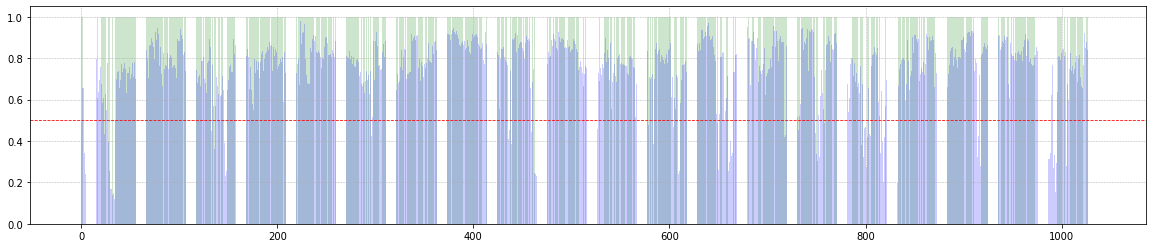

In [651]:
plt.figure(figsize=(20,4))
plt.bar(sampling2.index, sampling2['answerCode'], color='green', alpha=0.2)
plt.bar(sampling2.index, sampling2['y_pred'], color='blue', alpha=0.2)
plt.axhline(y=0.5, color='red', linestyle='--', linewidth=0.8)
plt.grid(linestyle='--', linewidth=0.5)
plt.show(); # 그래프가 안보이는 부분은 0 일 때 0을 거의 맞춘 것. 무조건 틀리는 게 있는가?

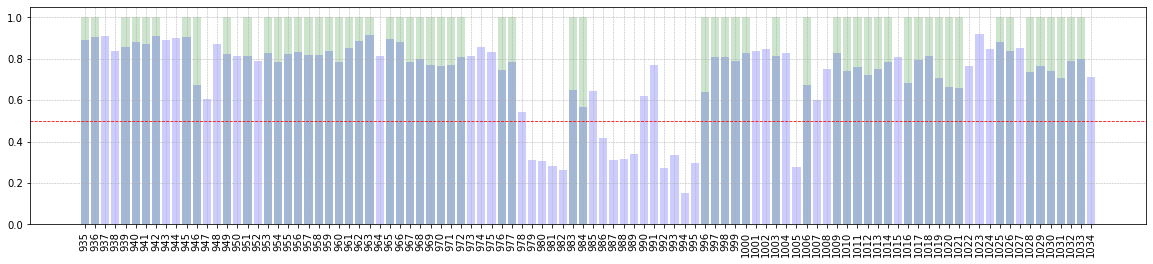

In [652]:
plt.figure(figsize=(20,4))
plt.bar(sampling2.iloc[-100:].index, sampling2.iloc[-100:]['answerCode'], color='green', alpha=0.2)
plt.bar(sampling2.iloc[-100:].index, sampling2.iloc[-100:]['y_pred'], color='blue', alpha=0.2)
#plt.bar(sampling2.iloc[-100:].index, sampling2.iloc[-100:]['diff'], color='blue', alpha=0.2)
plt.axhline(y=0.5, color='red', linestyle='--', linewidth=0.8)
plt.grid(linestyle='--', linewidth=0.5)
plt.xticks(np.arange(935,1035), rotation=90)
plt.show();

In [693]:
s = sampling2.iloc[-100:]
s_zero = s[s['answerCode']==0] 
s_one = s[s['answerCode']==1]

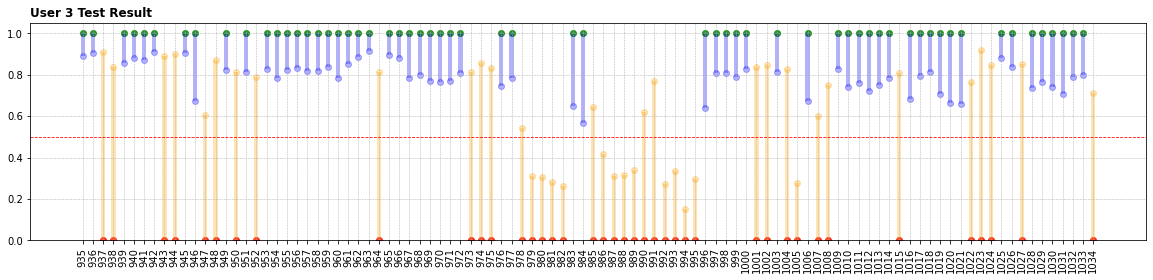

In [727]:
plt.figure(figsize=(20,4))
plt.scatter(s_zero.index, s_zero['answerCode'], color='red', alpha=0.8)
plt.scatter(s_zero.index, s_zero['y_pred'], color='orange', alpha=0.3)
plt.bar(s_zero.index, s_zero['diff'], color='orange', alpha=0.3, width=0.4)

plt.scatter(s_one.index, s_one['answerCode'], color='green', alpha=0.8)
plt.scatter(s_one.index, s_one['y_pred'], color='blue', alpha=0.3)
plt.bar(s_one.index, height=1-s_one['y_pred'], color='blue', alpha=0.3, width=0.4, bottom=s_one['y_pred'])

plt.axhline(y=0.5, color='red', linestyle='--', linewidth=0.8)
plt.grid(linestyle='--', linewidth=0.5)
plt.xticks(np.arange(935,1035), rotation=90)
plt.title(f"User 3 Test Result", loc='left', weight='bold')
plt.show();

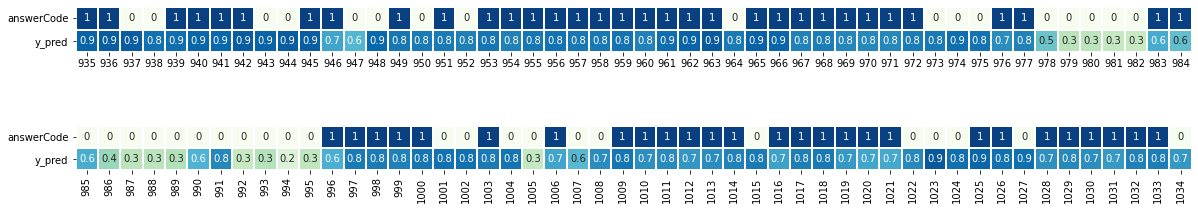

In [730]:
fig, axes = plt.subplots(2,1, figsize=(20,4))
sns.heatmap(s[['answerCode','y_pred']].iloc[:50].transpose(), cbar=False, annot=True, square=True, fmt='.1g', linewidths=0.1, cmap='GnBu', ax=axes[0])
sns.heatmap(s[['answerCode','y_pred']].iloc[50:].transpose(), cbar=False, annot=True, square=True, fmt='.1g', linewidths=0.1, cmap='GnBu', ax=axes[1])
plt.show();

In [769]:
s.head()

,userID,assessmentItemID,testId,answerCode,Timestamp,KnowledgeTag,time,test_group,temp_test,time_cum,meantime_3,total_used_time,user_correct_answer,user_total_answer,user_acc,total_prob,test_mean,test_sum,tag_mean,tag_sum,y_pred,diff
935,3,A050137004,50000137,1,2020-09-22 14:54:42,427,26.0,5,1,91.0,30.333333,47752.0,657.0,935,0.702674,379.0,0.840000,147,0.780543,345,0.889863,0.110137
936,3,A050137005,50000137,1,2020-09-22 14:54:53,427,11.0,5,1,102.0,18.666667,47778.0,658.0,936,0.702991,378.0,0.840000,147,0.780543,345,0.904461,0.095539
937,3,A050137006,50000137,0,2020-09-22 14:55:06,427,13.0,5,1,115.0,16.666667,47789.0,659.0,937,0.703308,377.0,0.840000,147,0.780543,345,0.911504,0.911504
938,3,A050137007,50000137,0,2020-09-22 14:55:54,427,48.0,5,1,163.0,24.000000,47802.0,659.0,938,0.702559,377.0,0.840000,147,0.780543,345,0.836986,0.836986
939,3,A050113001,50000113,1,2020-09-24 07:16:25,5285,0.0,5,0,0.0,20.333333,47850.0,659.0,939,0.701810,377.0,0.797619,134,0.738819,413,0.854405,0.145595


In [ ]:
roc_auc_score(s)

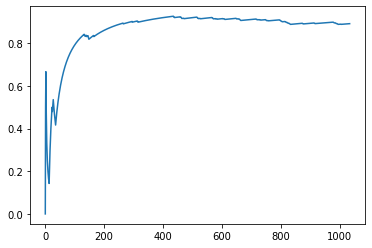

In [749]:
plt.plot(sampling2['accuracy']);

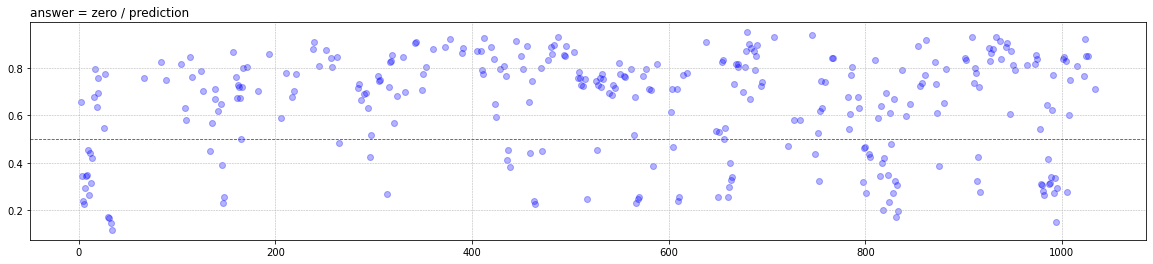

In [672]:
# 제대로 한다면 맞은문제 틀린문제 모두 고려
sampling_one = sampling2[sampling2['answerCode']==1]
sampling_zero = sampling2[sampling2['answerCode']==0]
plt.figure(figsize=(20,4))
plt.scatter(sampling_zero.index, sampling_zero['y_pred'], color='blue', alpha=0.3)
#plt.bar(sampling2.iloc[-100:].index, sampling2.iloc[-100:]['diff'], color='blue', alpha=0.2)
plt.axhline(y=0.5, color='red', linestyle='--', linewidth=0.8)
plt.grid(linestyle='--', linewidth=0.5)
plt.title("answer = zero / prediction", loc='left')
plt.show();

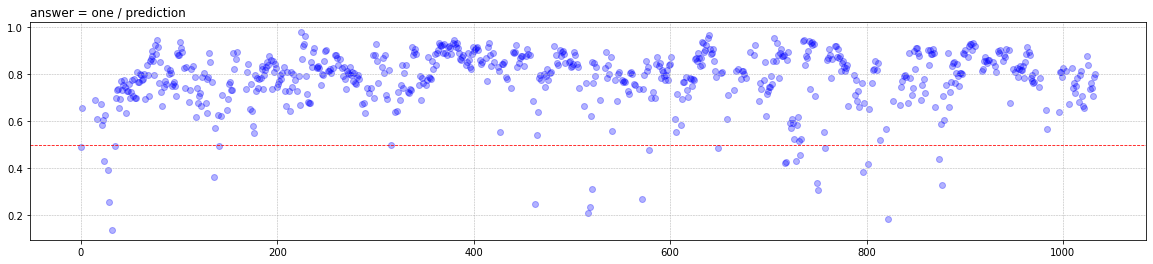

In [673]:
plt.figure(figsize=(20,4))
plt.scatter(sampling_one.index, sampling_one['y_pred'], color='blue', alpha=0.3)
#plt.bar(sampling2.iloc[-100:].index, sampling2.iloc[-100:]['diff'], color='blue', alpha=0.2)
plt.axhline(y=0.5, color='red', linestyle='--', linewidth=0.8)
plt.grid(linestyle='--', linewidth=0.5)
plt.title("answer = one / prediction", loc='left')
plt.show();

----
# MODEL PREDICTION RESULT

In [1407]:
plt.style.use('ggplot')

valid = pd.read_csv('valid_set.csv')
model = joblib.load('lgbm_model.pkl')
print(model)
with open('feature_pickle.pickle', 'rb') as f:
    FEATURES = pickle.load(f)

LGBMClassifier(n_estimators=500, num_leaves=255)


In [881]:
%%time
raw_test = '/opt/ml/input/data/train_dataset/test_data.csv'
#feat_test = 'test_set.csv'
raw_test = pd.read_csv(raw_test)
raw_test = feature_engineering_origin(raw_test)
#feat_test = pd.read_csv(feat_test)

CPU times: user 17.9 s, sys: 552 ms, total: 18.5 s
Wall time: 18.6 s


In [886]:
%%time
test_df = feature_engineering(raw_test2) # 전체 0.5s

CPU times: user 536 ms, sys: 0 ns, total: 536 ms
Wall time: 539 ms


In [1521]:
(raw['pred'] > 0.5).astype('int')

0      1
1      1
2      0
3      1
4      1
      ..
739    0
740    1
741    1
742    1
743    1
Name: pred, Length: 744, dtype: int64

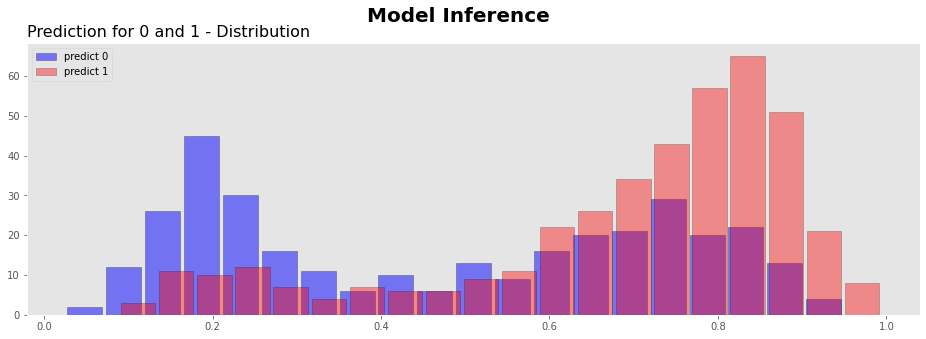

Accuracy_score : 69.0 %
ROC_AUC_score : 74.4 %


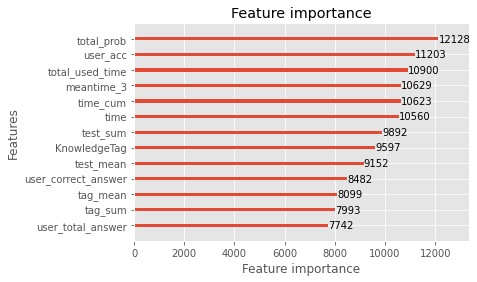

In [1552]:
def inference(test_df):

    def set_df(test, features):
        test2 = test[test['userID'] != test['userID'].shift(-1)]
        y = test2['answerCode']
        return test2, test2[features], y
    
    def zero_one_distribution(df):
        zero = df[df['answerCode']==0]
        one = df[df['answerCode']==1]
        plt.figure(figsize=(16,5))
        plt.hist(zero['pred'], bins=20,rwidth=0.9, alpha=0.5, label='predict 0', color='blue', edgecolor='black')
        plt.hist(one['pred'], bins=20,rwidth=0.9, alpha=0.4, label='predict 1', color='red', edgecolor='black')
        plt.legend(loc='upper left')
        plt.title('Prediction for 0 and 1 - Distribution', loc='left', size=16)
        plt.suptitle("Model Inference", fontweight='bold', size=20)
        plt.grid()
        plt.show();

    raw, testing, y = set_df(test_df, FEATURES)
    result = model.predict_proba(testing)
    raw['pred'] = result[:,1]
    raw = pd.merge(raw, prob_count, how='left', on = 'userID')
    raw = raw[['userID','test_group','prob_count','total_prob','user_acc','total_used_time','answerCode','pred']]

    zero_one_distribution(raw)
    
    lgb.plot_importance(model);
    threshold = 0.5
    print(f"Accuracy_score : {accuracy_score(y, (raw['pred'] > threshold).astype('int'))*100:.1f} %")
    print(f"ROC_AUC_score : {roc_auc_score(y, raw['pred'])*100:.1f} %")
    
    return raw

raw = inference(test_df)

### 모델의 Feature importance
* 영향을 가장 많이 준 컬럼은 [total_prob, user_acc, total_used_time] 세 가지 이다.
* total_prob : 총 문제풀이 수 에 관련된 컬럼
* user_acc : 유저가 푼 문제의 정답률
* total_used_time : 유저가 문제푸는데 사용한 총 시간

{   
    {      
           plot: img_url,
           description: text
    },
}

In [1553]:
display(raw.head(), raw.shape)

,userID,test_group,prob_count,total_prob,user_acc,total_used_time,answerCode,pred
0,3,5,1036,318.0,0.693424,52936.0,0,0.720737
1,4,7,671,206.0,0.693572,58441.0,1,0.871286
2,13,7,1317,402.0,0.695057,165673.0,1,0.403813
3,17,9,1260,229.0,0.818760,142566.0,1,0.851938
4,26,6,387,93.0,0.761039,12726.0,0,0.807643


(744, 8)

### 모델의 예측 결과 확률값 분포
* 0을 예측하는 확률 값은 0에 가깝게, 1을 예측하는 확률 값은 1에 가깝게 분포가 분리되어 형성될 수록 좋은 예측이라고 볼 수 있다.
* 전반적으로 1을 더 잘 맞추는 쪽으로 분포가 잘 형성된 것을 볼 수 있다.

유저별 문제를 푼 종류, 문제 수 등이 다르기 때문에 상위 3개 column 에 대해서 시각화해보자.

In [ ]:
def test_group_draw(raw):
    
    def test_group_accuracy(raw):
        raw_tgroup = raw.groupby('test_group')['answerCode'].mean()
        plt.figure(figsize=(12,5))
        plt.bar(raw_tgroup.index, raw_tgroup.values, edgecolor='black')
        for i in range(9):
            plt.text(i-0.2, raw_tgroup[i]+0.02, f"{raw_tgroup[i]*100:.1f}%")
        plt.title('User mean accuracy by Test_group in test_data', loc='left', weight='bold')
        plt.ylim([0,1])
        plt.show();
    
    test_group_accuracy(raw)
    
    fig, axes = plt.subplots(3,3,figsize=(20,12))

    temp = raw[['test_group','answerCode','pred']]

    for i in range(1,10):
        temp2 = temp[temp['test_group']==f'{i}']
        zero = temp2[temp2['answerCode']==0].sort_values(by='pred',ascending=False)
        one = temp2[temp2['answerCode']==1].sort_values(by='pred',ascending=False)

        axes[(i-1)//3][(i-1)%3].plot(np.arange(len(zero)), zero['pred'], label='zero prediction', alpha=0.5, color='orange', marker='o')
        axes[(i-1)//3][(i-1)%3].plot(np.arange(len(one)), one['pred'], label='one prediction', alpha=0.5, color='blue', marker='^')

        axes[(i-1)//3][(i-1)%3].fill_between(np.arange(len(zero)), zero['pred'], y2=0, alpha=0.2, color='orange')
        axes[(i-1)//3][(i-1)%3].fill_between(np.arange(len(one)), one['pred'], y2=1, alpha=0.2, color='blue')

        axes[(i-1)//3][(i-1)%3].set_title(f"test_group : {i}, sample count of group : {len(temp2)}")
        axes[(i-1)//3][(i-1)%3].axhline(0.5, color='green', linestyle='--')
        axes[(i-1)//3][(i-1)%3].legend(loc='lower right')
        axes[(i-1)//3][(i-1)%3].set_ylim([0,1])

    plt.suptitle('Difference between prediction and answer by test_group')    
    plt.tight_layout()
    plt.show();
    
test_group_draw(raw)

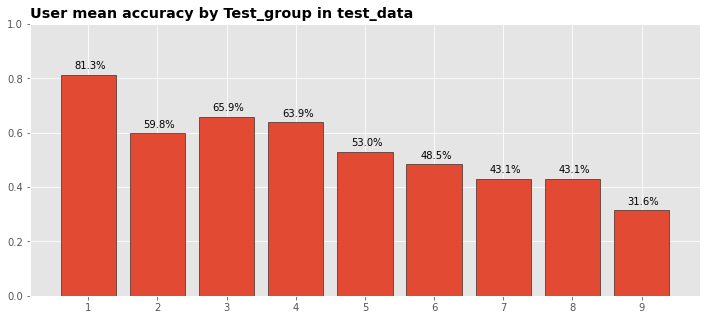

In [1556]:
def test_group_accuracy(raw):
    raw_tgroup = raw.groupby('test_group')['answerCode'].mean()
    plt.figure(figsize=(12,5))
    plt.bar(raw_tgroup.index, raw_tgroup.values, edgecolor='black')
    for i in range(9):
        plt.text(i-0.2, raw_tgroup[i]+0.02, f"{raw_tgroup[i]*100:.1f}%")
    plt.title('User mean accuracy by Test_group in test_data', loc='left', weight='bold')
    plt.ylim([0,1])
    plt.show();
    
test_group_accuracy(raw)

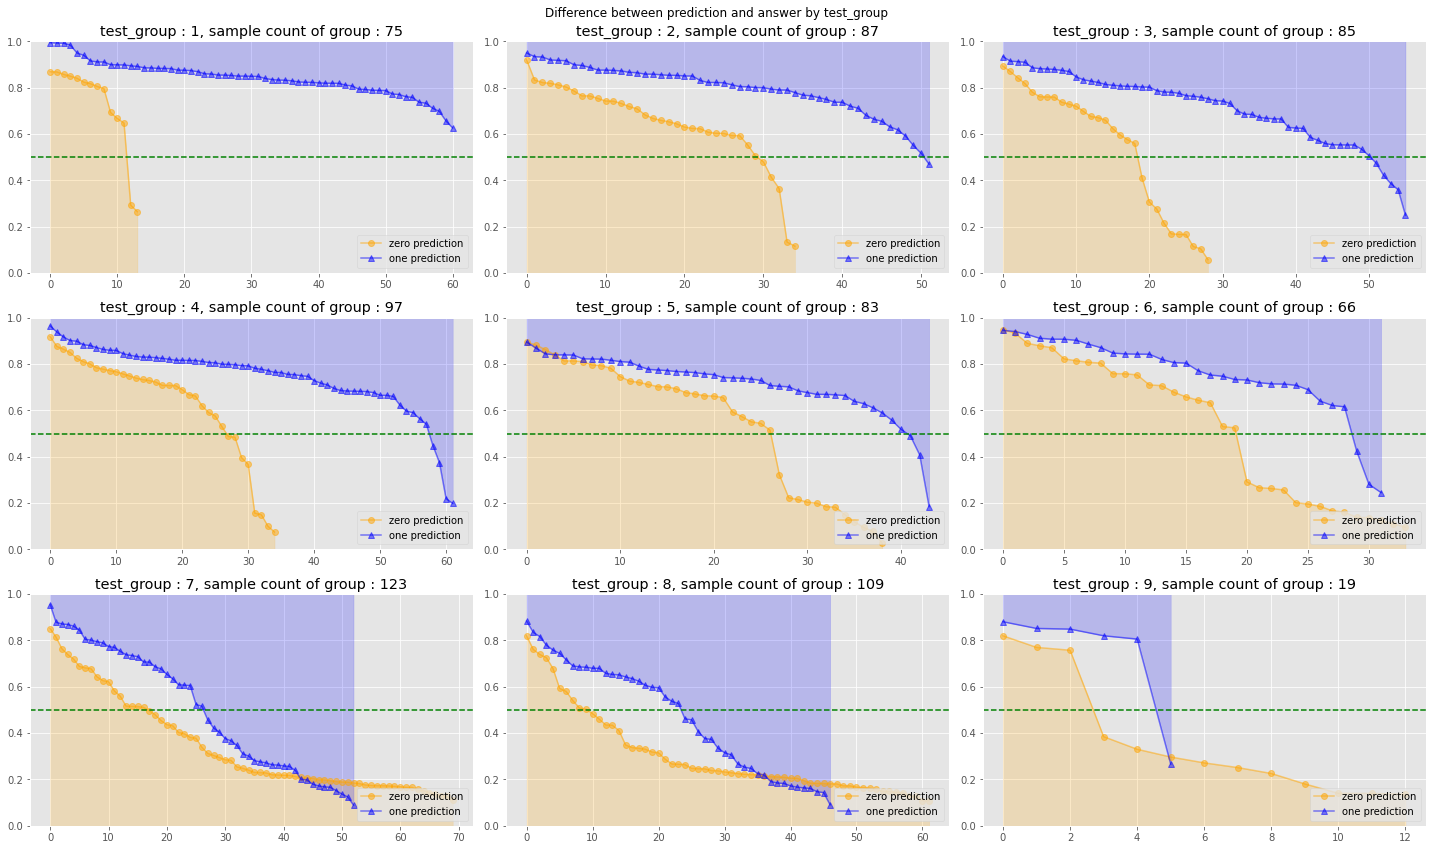

In [1555]:
def test_group_draw(raw):
    fig, axes = plt.subplots(3,3,figsize=(20,12))

    temp = raw[['test_group','answerCode','pred']]

    for i in range(1,10):
        temp2 = temp[temp['test_group']==f'{i}']
        zero = temp2[temp2['answerCode']==0].sort_values(by='pred',ascending=False)
        one = temp2[temp2['answerCode']==1].sort_values(by='pred',ascending=False)

        axes[(i-1)//3][(i-1)%3].plot(np.arange(len(zero)), zero['pred'], label='zero prediction', alpha=0.5, color='orange', marker='o')
        axes[(i-1)//3][(i-1)%3].plot(np.arange(len(one)), one['pred'], label='one prediction', alpha=0.5, color='blue', marker='^')

        axes[(i-1)//3][(i-1)%3].fill_between(np.arange(len(zero)), zero['pred'], y2=0, alpha=0.2, color='orange')
        axes[(i-1)//3][(i-1)%3].fill_between(np.arange(len(one)), one['pred'], y2=1, alpha=0.2, color='blue')

        axes[(i-1)//3][(i-1)%3].set_title(f"test_group : {i}, sample count of group : {len(temp2)}")
        axes[(i-1)//3][(i-1)%3].axhline(0.5, color='green', linestyle='--')
        axes[(i-1)//3][(i-1)%3].legend(loc='lower right')
        axes[(i-1)//3][(i-1)%3].set_ylim([0,1])

    plt.suptitle('Difference between prediction and answer by test_group')    
    plt.tight_layout()
    plt.show();
    
test_group_draw(raw)

### test_group 별 Prediction 과 Answer 사이의 오차
그래프의 면적이 작을수록 각 label 에 해당하는 Prediction 이 잘 이루어졌다고 볼 수 있다.  
전반적으로 test_group number 가 올라갈수록,

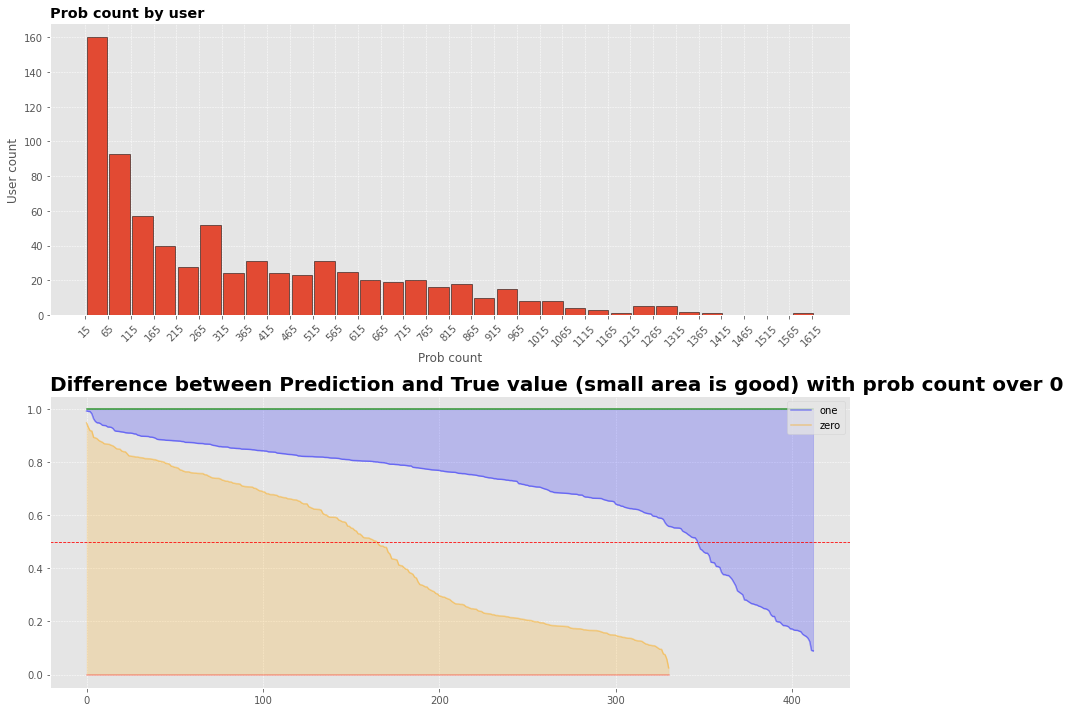

CPU times: user 624 ms, sys: 16 ms, total: 640 ms
Wall time: 640 ms


In [1506]:
%%time
def difference_by_count(raw, count=0):
    one = raw[(raw['prob_count'] > count) & (raw['answerCode'] == 1)].sort_values(by='pred', ascending=False)
    zero = raw[(raw['prob_count'] > count) & (raw['answerCode'] == 0)].sort_values(by='pred', ascending=False)
    
    fig, axes = plt.subplots(2,1, figsize=(12,10))

    axes[0].hist(raw['prob_count'], bins=32, rwidth=0.9, edgecolor='black')
    axes[0].set_xticks(np.arange(15,1620,50))
    axes[0].set_xticklabels(np.arange(15,1620,50), rotation=45)
    axes[0].set_title("Prob count by user", loc='left', weight='bold')
    axes[0].grid(linestyle='--', linewidth=0.5)
    axes[0].set_ylabel('User count')
    axes[0].set_xlabel('Prob count')
    
    axes[1].plot(np.arange(len(one)), one['answerCode'], color='green', alpha=0.8)
    axes[1].plot(np.arange(len(one)), one['pred'], color='blue', alpha=0.4, label = 'one')
    axes[1].fill_between(np.arange(len(one)), one['pred'],y2=1, color='blue', alpha = 0.2)

    axes[1].plot(np.arange(len(zero)), zero['answerCode'], color='red', alpha=0.3)
    axes[1].plot(np.arange(len(zero)), zero['pred'], color='orange', alpha=0.4, label='zero')
    axes[1].fill_between(np.arange(len(zero)), zero['pred'], color='orange', alpha = 0.2)

    axes[1].axhline(y=0.5, color='red', linestyle='--', linewidth=0.8)
    axes[1].grid(linestyle='--', linewidth=0.5)

    axes[1].legend(loc='upper right')
    axes[1].set_title(f'Difference between Prediction and True value (small area is good) with prob count over {count}', loc='left', weight='bold', size=20)
    
    plt.tight_layout()
    #plt.savefig('sample.png')
    plt.show();
    
difference_by_count(raw, count=0)

### 문제풀이 수 컬럼 관련 Prediction 값과 True 값의 차이 분포
* 문제풀이 수 에 해당하는 조건을 더 주고 Prediction 값과 True 값 사이의 오차가 어떻게 변하는지 알아본다.

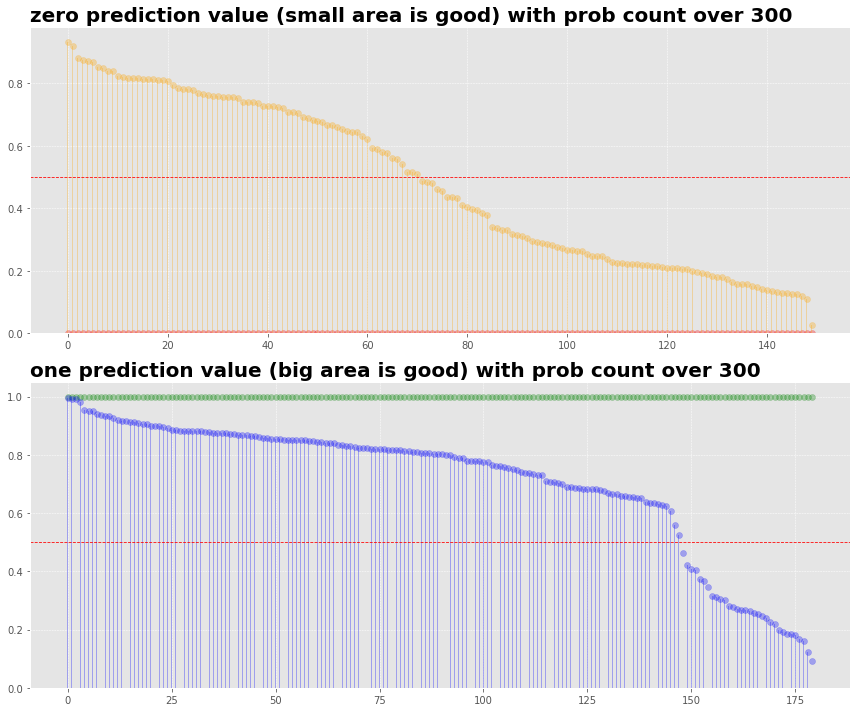

CPU times: user 1.1 s, sys: 0 ns, total: 1.1 s
Wall time: 1.1 s


In [1410]:
%%time
def zero_one_by_count(raw, count=0):
    one = raw[(raw['prob_count'] > count) & (raw['answerCode'] == 1)].sort_values(by='pred', ascending=False)
    zero = raw[(raw['prob_count'] > count) & (raw['answerCode'] == 0)].sort_values(by='pred', ascending=False)
    
    fig, axes = plt.subplots(2,1, figsize=(12,10))
    axes[0].scatter(np.arange(len(zero)), zero['answerCode'], color='red', alpha=0.3)
    axes[0].scatter(np.arange(len(zero)), zero['pred'], color='orange', alpha=0.3)
    axes[0].bar(np.arange(len(zero)), zero['pred'], color='orange', alpha=0.3, width=0.2)

    axes[0].axhline(y=0.5, color='red', linestyle='--', linewidth=0.8)
    axes[0].grid(linestyle='--', linewidth=0.5)
    axes[0].set_title(f'zero prediction value (small area is good) with prob count over {count}', loc='left', weight='bold', size=20)

    axes[1].scatter(np.arange(len(one)), one['answerCode'], color='green', alpha=0.3)
    axes[1].scatter(np.arange(len(one)), one['pred'], color='blue', alpha=0.3)
    axes[1].bar(np.arange(len(one)), one['pred'], color='blue', alpha=0.3, width=0.2)

    axes[1].axhline(y=0.5, color='red', linestyle='--', linewidth=0.8)
    axes[1].grid(linestyle='--', linewidth=0.5)
    axes[1].set_title(f'one prediction value (big area is good) with prob count over {count}', loc='left', weight='bold', size=20)
    
    plt.tight_layout()
    plt.show();
    
zero_one_by_count(raw, count=300)

### 특정 문제 수 이상을 푼 유저에 한해서, 정답값이 0 과 1 일 때 예측값
* 특정 문제 수 이상을 푼 유저에 한해서, 정답값이 0 과 1 일 때 예측을 잘 하는지 분포를 알아보자.

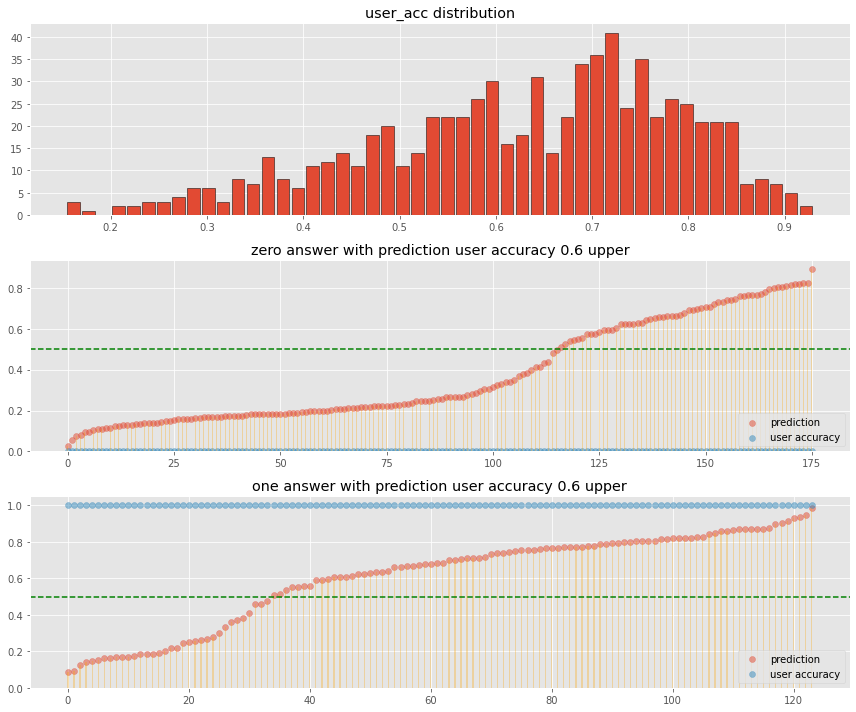

CPU times: user 2.21 s, sys: 12 ms, total: 2.22 s
Wall time: 2.22 s


In [1501]:
%%time
def user_accuracy_prediction(raw, user_acc=0.6, check='upper'):
    fig, axes = plt.subplots(3,1, figsize=(12,10))

    axes[0].hist(raw['user_acc'], bins=50, rwidth=0.85, edgecolor='black')
    axes[0].set_title("user_acc distribution")

    user_acc = 0.6

    check = 'upper'
    if check == 'upper':
        raw_acc = raw[raw['user_acc'] < user_acc]    
    elif check == 'lower':
        raw_acc = raw[raw['user_acc'] < user_acc]

    acc_zero = raw_acc[raw_acc['answerCode']==0].sort_values(by='pred')
    axes[1].scatter(np.arange(len(acc_zero)), acc_zero['pred'], alpha=0.5, label = 'prediction')
    axes[1].scatter(np.arange(len(acc_zero)), acc_zero['answerCode'], alpha=0.5, label = 'user accuracy')
    axes[1].bar(np.arange(len(acc_zero)), acc_zero['pred'], color='orange', alpha=0.3, width=0.2)
    axes[1].legend(loc='lower right')
    axes[1].set_title(f'zero answer with prediction user accuracy {user_acc} {check}')
    axes[1].axhline(0.5, linestyle='--', color='green')

    acc_one = raw_acc[raw_acc['answerCode']==1].sort_values(by='pred')
    axes[2].scatter(np.arange(len(acc_one)), acc_one['pred'], alpha=0.5, label = 'prediction')
    axes[2].scatter(np.arange(len(acc_one)), acc_one['answerCode'], alpha=0.5, label = 'user accuracy')
    axes[2].bar(np.arange(len(acc_one)), acc_one['pred'], color='orange', alpha=0.3, width=0.2)
    axes[2].legend(loc='lower right')
    axes[2].set_title(f'one answer with prediction user accuracy {user_acc} {check}')
    axes[2].axhline(0.5, linestyle='--', color='green')
    
    plt.tight_layout()
    plt.show();
    
user_accuracy_prediction(raw, user_acc=0.6, check='upper')
# 정답률이 낮은 user에 한해서 zero 값을 더 잘 맞추는 것을 볼 수 있다.
# 정답률이 높은 user에 한해서 one 값을 더 잘 맞추는 것을 볼 수 있다.

### 각 유저의 정확도 분포 및 Prediction 값과 정답 사이의 오차
* 특정 정확도 이상 혹은 이하 유저에 한해서 Prediction 값의 분포가 어떻게 변하는지 알아보자.

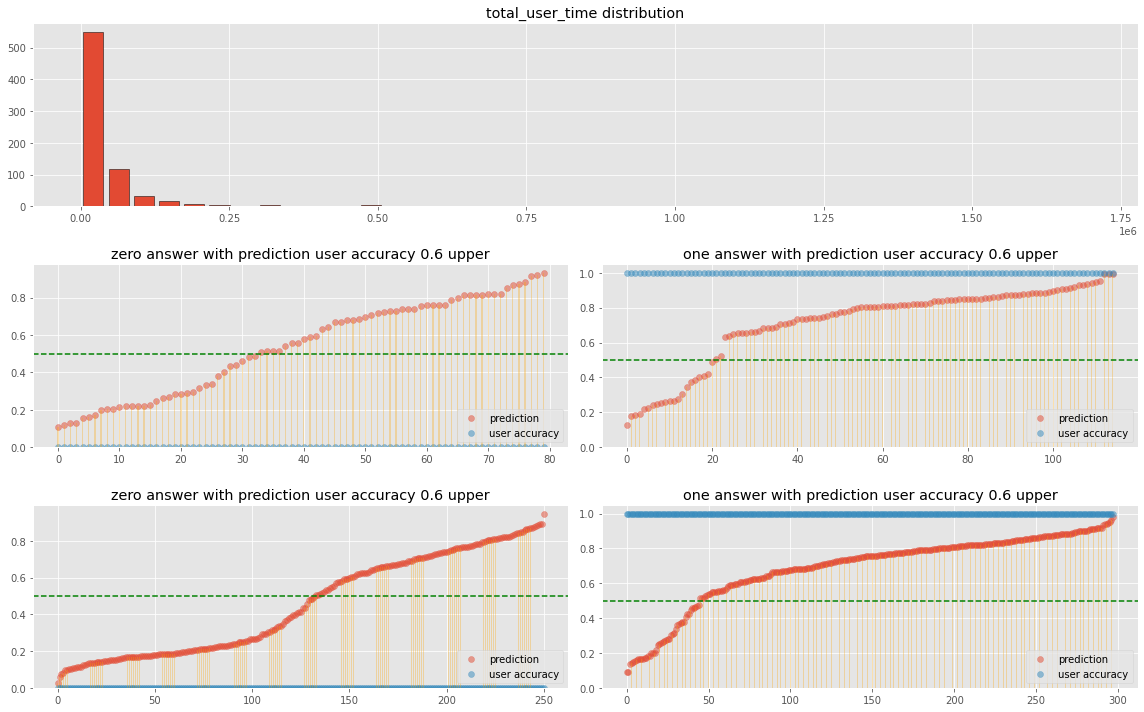

CPU times: user 2.46 s, sys: 8 ms, total: 2.47 s
Wall time: 2.46 s


In [1503]:
%%time
def total_time_with_prediction(raw):
    fig = plt.figure(figsize=(16,10))

    ax0 = plt.subplot(3,1,1)
    ax1 = plt.subplot(3,2,3)
    ax2 = plt.subplot(3,2,4)
    ax3 = plt.subplot(3,2,5)
    ax4 = plt.subplot(3,2,6)

    a = ax0.hist(raw['total_used_time'], bins=40, rwidth=0.8, edgecolor='black')[1][1]
    ax0.set_title("total_user_time distribution")

    raw_upper = raw[raw['total_used_time'] > a]
    raw_lower = raw[raw['total_used_time'] < a]

    acc_zero = raw_upper[raw_upper['answerCode']==0].sort_values(by='pred')
    ax1.scatter(np.arange(len(acc_zero)), acc_zero['pred'], alpha=0.5, label = 'prediction')
    ax1.scatter(np.arange(len(acc_zero)), acc_zero['answerCode'], alpha=0.5, label = 'user accuracy')
    ax1.bar(np.arange(len(acc_zero)), acc_zero['pred'], color='orange', alpha=0.3, width=0.2)
    ax1.legend(loc='lower right')
    ax1.set_title(f'zero answer with prediction user accuracy {user_acc} {check}')
    ax1.axhline(0.5, linestyle='--', color='green')

    acc_one = raw_upper[raw_upper['answerCode']==1].sort_values(by='pred')
    ax2.scatter(np.arange(len(acc_one)), acc_one['pred'], alpha=0.5, label = 'prediction')
    ax2.scatter(np.arange(len(acc_one)), acc_one['answerCode'], alpha=0.5, label = 'user accuracy')
    ax2.bar(np.arange(len(acc_one)), acc_one['pred'], color='orange', alpha=0.3, width=0.2)
    ax2.legend(loc='lower right')
    ax2.set_title(f'one answer with prediction user accuracy {user_acc} {check}')
    ax2.axhline(0.5, linestyle='--', color='green')

    acc_zero = raw_lower[raw_lower['answerCode']==0].sort_values(by='pred')
    ax3.scatter(np.arange(len(acc_zero)), acc_zero['pred'], alpha=0.5, label = 'prediction')
    ax3.scatter(np.arange(len(acc_zero)), acc_zero['answerCode'], alpha=0.5, label = 'user accuracy')
    ax3.bar(np.arange(len(acc_zero)), acc_zero['pred'], color='orange', alpha=0.3, width=0.2)
    ax3.legend(loc='lower right')
    ax3.set_title(f'zero answer with prediction user accuracy {user_acc} {check}')
    ax3.axhline(0.5, linestyle='--', color='green')

    acc_one = raw_lower[raw_lower['answerCode']==1].sort_values(by='pred')
    ax4.scatter(np.arange(len(acc_one)), acc_one['pred'], alpha=0.5, label = 'prediction')
    ax4.scatter(np.arange(len(acc_one)), acc_one['answerCode'], alpha=0.5, label = 'user accuracy')
    ax4.bar(np.arange(len(acc_one)), acc_one['pred'], color='orange', alpha=0.3, width=0.2)
    ax4.legend(loc='lower right')
    ax4.set_title(f'one answer with prediction user accuracy {user_acc} {check}')
    ax4.axhline(0.5, linestyle='--', color='green')

    plt.tight_layout()
    plt.show();
    
total_time_with_prediction(raw)

### 문제풀이 총 시간 및 정답값에 따른 Prediction 분포
* 문제 풀이 총 시간에 따른 User histogram 분포
* 특정 문제풀이 시간 이상 투자한 그룹과 이하 투자한 그룹별 Prediction 값과 정답값의 오차.

# TODO

1. Load raw Test data.
2. build function for feature engineering.
3. calculate how many rows be cut.
4. by cutting, inference test.